Running Notebook No.4 to build a Transformer NMT.

1. Mounting Google Drive...
Mounted at /content/gdrive

2. Loading tokenizers and padded data...
Done.

3. Splitting data into training (70%), validation (10%), and test (20%) sets...
Done.

4. Building Transformer model...
Done.

5. Model training...
Epoch 1, Training Loss: 3.9651, Validation Loss: 2.6072, Time: 0.63 min
Epoch 2, Training Loss: 2.2088, Validation Loss: 2.1881, Time: 0.46 min
Epoch 3, Training Loss: 1.7863, Validation Loss: 2.0648, Time: 0.46 min
Epoch 4, Training Loss: 1.5504, Validation Loss: 2.0264, Time: 0.46 min
Epoch 5, Training Loss: 1.3913, Validation Loss: 2.0250, Time: 0.46 min
Epoch 6, Training Loss: 1.2699, Validation Loss: 2.0263, Time: 0.46 min
Epoch 7, Training Loss: 1.1760, Validation Loss: 2.0492, Time: 0.46 min
Epoch 8, Training Loss: 1.1001, Validation Loss: 2.0681, Time: 0.46 min
Training completed. Best model from epoch 5 with Validation Loss = 2.0250
Best model saved to: /content/gdrive/My Drive/N

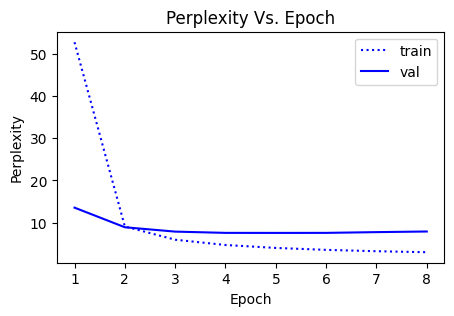

Evaluating model performance on test data...

Test Loss: 2.0110
Test Perplexity: 7.4711

6. Creating a translator instance with the trained Transformer...
Done.

7. Let's use the translator on a few examples...
Example 1
To be translated: 戸 に は 新しく ペンキ が 塗っ て あっ た 。
Reference translation: there was a new coat of paint on the door
Transformer output: the door was new paint
BLEU Score: 5.26
--------------------------------------------------------------------------------
Example 2
To be translated: 早く 起き なさい よ 、 じゃ ない と 遅刻 し ちゃう から ね 。
Reference translation: get up early or you'll be late
Transformer output: get up early you don't be late
BLEU Score: 20.56
--------------------------------------------------------------------------------
Example 3
To be translated: 僕 は 都会 の 生活 向き に 出来 て い ない と 思う 。
Reference translation: i don't think that i'm cut out for city life
Transformer output: i don't think i'm able to live in city
BLEU Score: 12.07
--------------------------------------------------

In [ ]:
"""
* This is the last notebook for my sequence-to-sequence Neural Machine Translation (NMT) project.
* The primary goal of this particular notebook is to compare the NMT's performance between a LSTM and a Transformer architecture.
* In this notebook, I structured the Transformer as documented in Vaswani et al, Attention Is All You Need.
* For more information, I highly recommend checking out TensorFlow's documentation "Neural machine translation with a Transformer and Keras".
* To run this notebook, modify the save_dir path below just like in the other notebooks.
"""

import os
import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import logging
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text
import warnings

# Constants and Configuration
BATCH_SIZE = 64
BUFFER_SIZE = 20000
MAX_TOKENS = 128
SAVE_DIR = '/content/gdrive/My Drive/NMT_Data'
MODEL_SAVE_DIR = os.path.join(SAVE_DIR, 'NMT_Models/Transformer')

# Model Configuration
num_layers = 1
d_model = 128
dff = 256
num_heads = 2
dropout_rate = 0.1
epochs = 8
warmup_steps = 1000

# Mount Google Drive
def mount_drive():
    from google.colab import drive
    drive.mount('/content/gdrive')

# Load saved data
def load_data_and_tokenizers(save_dir):
    padded_en = np.load(os.path.join(save_dir, 'padded_english.npy'))
    padded_ja = np.load(os.path.join(save_dir, 'padded_japanese.npy'))
    with open(os.path.join(save_dir, 'english_tokenizer.pkl'), 'rb') as f:
        en_tok = pickle.load(f)
    with open(os.path.join(save_dir, 'japanese_tokenizer.pkl'), 'rb') as f:
        ja_tok = pickle.load(f)

    vocab_size_ja = len(ja_tok.word_index) + 1
    vocab_size_en = len(en_tok.word_index) + 1

    return padded_en, padded_ja, en_tok, ja_tok, vocab_size_ja, vocab_size_en

# Function to create tf.data.Dataset with tokenized sequences
def prepare_batch(ja, en):
    ja_tensor = tf.convert_to_tensor(ja)
    en_tensor = tf.convert_to_tensor(en)

    en_inputs = en_tensor[:, :-1]
    en_labels = en_tensor[:, 1:]
    return (ja_tensor, en_inputs), en_labels

# Create TensorFlow datasets
def make_batches(x_en, x_ja):
    dataset = tf.data.Dataset.from_tensor_slices((x_ja, x_en))
    return (dataset
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .map(prepare_batch, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(buffer_size=tf.data.AUTOTUNE))

# Split and create datasets
def prepare_datasets(padded_en, padded_ja):
    train_en, temp_en, train_ja, temp_ja = train_test_split(padded_en, padded_ja, test_size=0.3, random_state=42)
    val_en, test_en, val_ja, test_ja = train_test_split(temp_en, temp_ja, test_size=2/3, random_state=42)

    train_batches = make_batches(train_en, train_ja)
    val_batches = make_batches(val_en, val_ja)
    test_batches = make_batches(test_en, test_ja)

    return (train_batches, val_batches, test_batches,
            train_ja, train_en, val_ja, val_en, test_ja, test_en)

# Positional encoding
def positional_encoding(length, depth):
    assert depth % 2 == 0, # depth must be even for alternating sin/cos

    positions = np.arange(length)[:, np.newaxis] # (length, 1)
    dims = np.arange(depth)[np.newaxis, :] # (1, depth)

    angle_rates = 1 / np.power(10000, (2 * (dims//2)) / depth)
    angle_rads = positions * angle_rates # (length, depth)

    # apply sin to even indices (0, 2, 4, ...) and cos to odd (1, 3, 5, ...)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = tf.convert_to_tensor(angle_rads, dtype=tf.float32)
    return pos_encoding # (length, depth)

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

# Define base attention (attention -> layer norm -> residual connection)
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

# Cross Attention connecting encoder and decoder
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # cache the attention scores if needed for analysis
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

# Global Self Attention in the encoder
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

# Global Self Attention but masked (in the decoder for autoregression)
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

# Just an FFN after attention (with residual connection and layer norm)
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

# Building the encoder layer (global self attention + FFN)
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

# Build the encoder with an encoder layer and embedding
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    x = self.pos_embedding(x)  # (batch_size, seq_len, d_model)
    x = self.dropout(x) # add dropout

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

# Building the decoder layer
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # (batch_size, seq_len, d_model)
    return x

# Building the decoder
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    x = self.pos_embedding(x)
    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    return x

# Building the Transformer NMT
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    context, x  = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)
    x = self.decoder(x, context)  # (batch_size, target_len, d_model)
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      del logits._keras_mask # will handle masked calculations manually
    except AttributeError:
      pass

    return logits

# Custom Training (Adam, with a lr rate scheduler)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=1000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# Set up masked loss
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

# Forward and backward pass
@tf.function
def train_step(model, optimizer, inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = masked_loss(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function
def val_step(model, inputs, labels):
    predictions = model(inputs, training=False)
    loss = masked_loss(labels, predictions)
    return loss

# Custom training loop
def custom_training_loop(model, optimizer, train_batches, val_batches, epochs, model_save_dir=None):
    train_loss_results = []
    val_loss_results = []
    best_val_loss = float('inf')
    best_weights = None
    best_epoch = -1

    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        val_loss_avg = tf.keras.metrics.Mean()
        start_time = time.time()

        # training
        for inputs, labels in train_batches:
            loss = train_step(model, optimizer, inputs, labels)
            epoch_loss_avg(loss)

        # validation
        for inputs, labels in val_batches:
            val_loss = val_step(model, inputs, labels)
            val_loss_avg(val_loss)

        train_loss = epoch_loss_avg.result()
        val_loss = val_loss_avg.result()

        train_loss_results.append(train_loss)
        val_loss_results.append(val_loss)

        # save the temporary best model weights
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.get_weights()
            best_epoch = epoch + 1

        # epoch summary
        epoch_time = (time.time() - start_time) / 60
        print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} min")

    # load best model
    model.set_weights(best_weights)
    print(f"Training completed. Best model from epoch {best_epoch} with Validation Loss = {best_val_loss:.4f}")

    # save the final best model after training is completed
    if model_save_dir:
        os.makedirs(model_save_dir, exist_ok=True)
        model_path = os.path.join(model_save_dir, 'best_transformer_model.weights.h5')
        model.save_weights(model_path)
        print(f"Best model saved to: {model_save_dir}")

    return train_loss_results, val_loss_results

# Plot training progress with perplexity
def plot_perplexity(train_loss, val_loss):
    train_perplexity = np.exp(train_loss)
    val_perplexity = np.exp(val_loss)

    plt.figure(figsize=(5, 3))
    plt.plot(range(1, len(train_perplexity)+1), train_perplexity, label='train', linestyle='dotted', color='blue')
    plt.plot(range(1, len(val_perplexity)+1), val_perplexity, label='val', linestyle='solid', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.title("Perplexity Vs. Epoch")
    plt.show()

# Evaluation on test dataset
def evaluate_on_test(model, test_batches):
    test_loss_avg = tf.keras.metrics.Mean()

    for inputs, labels in test_batches:
        test_loss = val_step(model, inputs, labels)
        test_loss_avg(test_loss)

    print(f"\nTest Loss: {test_loss_avg.result():.4f}")
    print(f"Test Perplexity: {np.exp(test_loss_avg.result()):.4f}")

# Build a translator class
class Translator(tf.Module):
    def __init__(self, ja_tok, en_tok, transformer, start_token='start', end_token='end', max_tokens=100):
        self.ja_tok = ja_tok
        self.en_tok = en_tok
        self.transformer = transformer
        self.start_token = start_token
        self.end_token = end_token
        self.start_token_id = en_tok.word_index[start_token]
        self.end_token_id = en_tok.word_index[end_token]
        self.max_tokens = max_tokens

    def __call__(self, sentence):
        if isinstance(sentence, str):
            sentence = [sentence]

        # convert Japanese sentence to input tensor
        encoder_input = self.ja_tok.texts_to_sequences(sentence)
        encoder_input = tf.keras.preprocessing.sequence.pad_sequences(encoder_input, padding='post')
        encoder_input = tf.convert_to_tensor(encoder_input)

        # initialize output with the [START] token
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, tf.constant([self.start_token_id], dtype=tf.int64))

        for i in tf.range(self.max_tokens):
            output = tf.transpose(output_array.stack())  # (1, current_seq_len)
            predictions = self.transformer([encoder_input, output], training=False)
            predictions = predictions[:, -1:, :]  # get last time step
            predicted_id = tf.argmax(predictions, axis=-1)

            output_array = output_array.write(i + 1, predicted_id[0])

            if predicted_id[0][0].numpy() == self.end_token_id:
                break

        output = tf.transpose(output_array.stack())  # (1, seq_len)
        output_tokens = output.numpy()[0]

        # convert token ids back to words
        index_word = self.en_tok.index_word
        translated_tokens = [index_word.get(id, '') for id in output_tokens if id != 0]
        translated_text = ' '.join(translated_tokens[1:-1])  # skip <start> and <end> for readability

        return translated_text, translated_tokens

# Calculate BLEU score for translated text
def rate_bleu_score(reference_text, translated_text, weights=(0.25, 0.25, 0.25, 0.25)):
    smoother = SmoothingFunction().method1
    reference_tokens = reference_text.split()
    candidate_tokens = translated_text.split()
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens, weights=weights, smoothing_function=smoother)
    return bleu_score

# Main function
def main():
    print("=" * 80)
    print("Running Notebook No.4 to build a Transformer NMT.")
    print("=" * 80)

    # Suppress User Warnings
    warnings.filterwarnings('ignore', category=UserWarning)

    # Mount Google Drive
    print("\n1. Mounting Google Drive...")
    mount_drive()

    # Load data from Drive
    print("\n2. Loading tokenizers and padded data...")
    padded_en, padded_ja, en_tok, ja_tok, vocab_size_ja, vocab_size_en = load_data_and_tokenizers(SAVE_DIR)
    print("Done.")

    # Prepare datasets
    print("\n3. Splitting data into training (70%), validation (10%), and test (20%) sets...")
    (train_batches, val_batches, test_batches,
     train_ja, train_en, val_ja, val_en, test_ja, test_en) = prepare_datasets(padded_en, padded_ja)
    print("Done.")

    # Build Transformer model
    print("\n4. Building Transformer model...")
    model = Transformer(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        input_vocab_size=vocab_size_ja,
        target_vocab_size=vocab_size_en,
        dropout_rate=dropout_rate)

    # Setup optimizer with learning rate schedule
    learning_rate = CustomSchedule(d_model, warmup_steps=warmup_steps)
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

    # Initialize model with a forward pass
    sample_inputs, sample_labels = next(iter(train_batches))
    _ = model(sample_inputs)
    print("Done.")

    # Train model
    print("\n5. Model training...")
    train_loss, val_loss = custom_training_loop(model, optimizer, train_batches, val_batches, epochs=epochs, model_save_dir=MODEL_SAVE_DIR)
    plot_perplexity(train_loss, val_loss)
    print("Evaluating model performance on test data...")
    evaluate_on_test(model, test_batches)

    # Create translator instance
    print("\n6. Creating a translator instance with the trained Transformer...")
    translator = Translator(ja_tok, en_tok, model, start_token='start', end_token='end', max_tokens=padded_en.shape[1])
    print("Done.")

    # Test translation on some examples
    print("\n7. Let's use the translator on a few examples...")
    indices_chosen = [10, 20, 30, 40, 50]
    for i, indice in enumerate(indices_chosen, 1):
        japanese_test = ja_tok.sequences_to_texts([test_ja[indice]])[0].replace('start', '').replace('end', '').strip()
        reference_translation = en_tok.sequences_to_texts([test_en[indice]])[0].replace('start', '').replace('end', '').strip()
        print(f'Example {i}')
        print(f'To be translated: {japanese_test}')
        print(f'Reference translation: {reference_translation}')

        # call translator
        translated_text, translated_tokens = translator(japanese_test)
        print(f'Transformer output: {translated_text}')

        # calculate BLEU score
        bleu_score = rate_bleu_score(reference_translation, translated_text)
        print(f'BLEU Score: {bleu_score * 100:.2f}') #  note BLEU is usually reported in range 0-100, but it is not a percentage.
        print('-' * 80)

    print("\n" + "=" * 80)
    print("Notebook 4 completed. How does the Transformer NMT compare to the previous models?")
    print("What differences have you noticed in the BLEU scores and translation quality?")
    print("Also, did you know these models are far from optimized in my notebooks?.")
    print("If you'd like, you can try making better models yourself using different parameters.")
    print("Well~ This is the end of my NMT series. I hope you had fun working along with me! 😊")
    print("If you have any questions or suggestions about this repo, feel free to reach out on LinkedIn.")
    print("Here is my profile: https://www.linkedin.com/in/saberyu/")
    print("=" * 80)

if __name__ == '__main__':
    main()